# Multimodal Music Emotion Recognition (MIREX)



## Ringkasan & Tujuan

Notebook ini mengimplementasikan model trimodal untuk klasifikasi emosi musik (5 kelas MIREX) berbasis kombinasi audio, lirik, dan MIDI. Fokus pendekatan ini adalah memanfaatkan Wav2Vec2 sebagai encoder audio dengan fine-tuning parsial, RoBERTa untuk teks, serta CNN ringan untuk piano-roll MIDI, yang digabungkan melalui mekanisme triple cross-attention.



Notebook dirancang sebagai baseline yang kuat dan stabil untuk keperluan eksperimen dan pelaporan tugas besar, dengan penekanan pada pengaturan training yang hati-hati (normalisasi audio, strategi freezing/unfreezing backbone, dan penanganan ketidakseimbangan kelas).

In [1]:
!pip install -q kagglehub transformers timm pretty_midi librosa tqdm nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 48.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.3 MB/s eta 0:00:0000:0100:

## Import Pustaka Inti



Memuat pustaka standar Python, modul pemrosesan audio/teks/MIDI, serta backbone model dari HuggingFace Transformers, timm, dan utilitas evaluasi yang digunakan di seluruh eksperimen.

In [2]:
import os
import random
import time
import json
import math
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from tqdm.auto import tqdm
from typing import Optional, List, Tuple

# Matplotlib & Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch & Audio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Audio & MIDI Processing
try:
    import librosa
    import pretty_midi
except ImportError:
    print("Librosa/PrettyMIDI not installed provided in environment, please pip install.")

# Transformers & Timm
from transformers import AutoTokenizer, AutoConfig, AutoModel
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Suppress Warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
def set_global_seed(seed=42):
    """Set seed untuk reproducibility di semua library"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Global seed set to {seed}")

set_global_seed(42)

Global seed set to 42


In [4]:
# --- CONFIG ---
class Config:
    IMG_SIZE = (256, 256)
    MIDI_FEAT_DIM = 8
    MAX_LYRIC_TOKENS = 384
    EMBED_DIM = 256      
    
    # Training Params
    EPOCHS = 50
    BATCH_SIZE = 16
    LR_BACKBONE = 5e-5
    LR_HEAD = 5e-4
    WEIGHT_DECAY = 1e-2
    PATIENCE = 7
    
    # Path Handling (Auto-detect Kaggle vs Local)
    if os.path.exists("/kaggle/input/multimodal-mirex-emotion-dataset/dataset"):
        DATA_ROOT = Path("/kaggle/input/multimodal-mirex-emotion-dataset/dataset")
    else:
        DATA_ROOT = Path("./dataset") # Fallback local

print(f"Using DATA_ROOT: {Config.DATA_ROOT}")
AUDIO_DIR = Config.DATA_ROOT / "Audio"
LYRIC_DIR = Config.DATA_ROOT / "Lyrics"
MIDI_DIR  = Config.DATA_ROOT / "MIDIs"
TXT_CLUST = Config.DATA_ROOT.parent / "clusters.txt" 
if not TXT_CLUST.exists(): TXT_CLUST = Config.DATA_ROOT / "clusters.txt"

# --- HELPER FUNCTIONS ---
def load_id2label() -> dict:
    id2y = {}
    if TXT_CLUST.exists():
        lines = TXT_CLUST.read_text(encoding="utf-8", errors="ignore").splitlines()
        for line in lines:
            # Cari angka pertama di baris (misal: "1" dari "Cluster 1")
            # Asumsi: Line number di text file merepresentasikan ID lagu jika berurutan
            # Atau format dataset: ID lagu mapping ke Cluster
            import re
            m = re.search(r"(\d+)", line)
            if m:
                # Disini kita asumsikan line ke-i adalah label untuk ID=i
                # Jika format textnya "SongID: ClusterX", perlu parsing beda.
                # Mengikuti kode asli Anda:
                 cl = int(m.group(1))
                 if 1 <= cl <= 5:
                     # Kita simpan di list nanti, ini helper baca file saja
                     pass
    return {} # Akan kita handle di main block agar lebih robust

def find_file(directory, file_id, extensions):
    for ext in extensions:
        p = directory / f"{file_id}{ext}"
        if p.exists(): return p
    return None

Using DATA_ROOT: /kaggle/input/multimodal-mirex-emotion-dataset/dataset


## Preprocessing Audio



Fungsi pemrosesan awal audio untuk Wav2Vec2 yang mencakup pemotongan/padding ke durasi tetap, normalisasi standar (mean 0, standar deviasi 1) agar stabil saat training, serta augmentasi sederhana (penambahan noise) sebagai regularisasi.

In [5]:
# --- REVISI: Preprocessing Audio (WAJIB NORMALISASI) ---
def audio_loader(path: Path, target_sr=16000, max_seconds=10, augment=False):
    if path is None:
        return torch.zeros(target_sr * max_seconds)
    
    try:
        # Load audio
        y, sr = librosa.load(str(path), sr=target_sr, duration=max_seconds, mono=True)
    except Exception:
        return torch.zeros(target_sr * max_seconds)

    # Padding / Cutting
    target_len = target_sr * max_seconds
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]

    # === BAGIAN PENTING YANG HILANG DI KODE ANDA ===
    # Normalisasi Standar (Mean=0, Std=1)
    # Tanpa ini, Wav2Vec2 PASTI loss=NaN
    mean = y.mean()
    std = y.std()
    if std > 1e-6:
        y = (y - mean) / std
    else:
        y = y - mean
    # ===============================================

    # Augmentasi
    if augment and random.random() < 0.5:
        noise = np.random.normal(0, 0.01, y.shape)
        y = y + noise

    return torch.from_numpy(y).float()

def spec_augment(mel, freq_mask=15, time_mask=35):
    # Mel: [1, F, T]
    aug = mel.clone()
    _, F, T = aug.shape
    
    # Frequency Masking
    f = random.randint(0, freq_mask)
    f0 = random.randint(0, max(0, F - f))
    aug[:, f0:f0+f, :] = 0
    
    # Time Masking
    t = random.randint(0, time_mask)
    t0 = random.randint(0, max(0, T - t))
    aug[:, :, t0:t0+t] = 0
    
    return aug

## Preprocessing MIDI



Konversi MIDI menjadi representasi piano-roll 2D berukuran tetap dan ekstraksi fitur simbolik sederhana (tempo, jumlah nada, durasi, densitas, dan fitur agregat lain) yang akan digunakan sebagai masukan ke encoder MIDI berbasis CNN.

In [6]:
def midi_to_pianoroll_image(path: Optional[Path], augment=False):
    # Jika path None atau error, kembalikan gambar kosong (Zeros)
    if path is None:
        return torch.zeros(1, *Config.IMG_SIZE, dtype=torch.float32)
        
    try:
        pm = pretty_midi.PrettyMIDI(str(path))
        
        # Augmentasi MIDI: Transposisi Nada
        if augment and random.random() < 0.5:
            shift = random.randint(-5, 5)
            for inst in pm.instruments:
                if not inst.is_drum:
                    for note in inst.notes:
                        note.pitch = max(0, min(127, note.pitch + shift))
        
        # Render Piano Roll
        roll = pm.get_piano_roll(fs=50) # fs=50 cukup untuk visualisasi
        roll = roll[21:109, :] # Crop standard piano keys
        
        # Resize ke 256x256
        img = torch.from_numpy(roll).float().unsqueeze(0).unsqueeze(0) # [1,1,H,W]
        img = F.interpolate(img, size=Config.IMG_SIZE, mode='bilinear', align_corners=False).squeeze(0)
        
        # Log scaling untuk visibilitas lebih baik
        img = torch.log1p(img)
        return img
    except Exception:
        return torch.zeros(1, *Config.IMG_SIZE, dtype=torch.float32)

def extract_midi_features(path: Optional[Path]):
    if path is None:
        return torch.zeros(Config.MIDI_FEAT_DIM, dtype=torch.float32)
    
    try:
        pm = pretty_midi.PrettyMIDI(str(path))
        tempo = pm.estimate_tempo()
        total_notes = sum([len(i.notes) for i in pm.instruments])
        duration = pm.get_end_time()
        density = total_notes / (duration + 1e-5)
        
        # Fitur statistik sederhana (dim=8)
        feat = np.array([tempo, total_notes, duration, density, 0, 0, 0, 0], dtype=np.float32)
        # Normalize simple
        feat = (feat - feat.mean()) / (feat.std() + 1e-6)
        return torch.from_numpy(feat).float()
    except Exception:
        return torch.zeros(Config.MIDI_FEAT_DIM, dtype=torch.float32)

## Dataloader



Definisi dataset dan fungsi `collate_fn` yang:

- Memuat audio (Wav2Vec2-ready), lirik, dan MIDI untuk setiap ID lagu.

- Menerapkan augmentasi hanya pada split training.

- Menyiapkan batch tensor terpad (audio, teks, dan MIDI) beserta mask yang diperlukan.

- Menyertakan flag keberadaan MIDI untuk menangani kasus modalitas yang hilang di tahap fusi.

In [7]:
class MIREXRobustDataset(Dataset):
    def __init__(self, ids, label_map, split="train", tokenizer_name="roberta-base"):
        self.ids = ids
        self.label_map = label_map
        self.split = split
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.augment = (split == "train")

    def __len__(self): return len(self.ids)

    def _load_lyrics(self, fid):
        path = find_file(LYRIC_DIR, fid, [".txt", ".lrc"])
        text = ""
        if path:
            try: text = path.read_text(encoding="utf-8", errors="ignore")
            except: pass
        
        tok = self.tokenizer(
            text, max_length=Config.MAX_LYRIC_TOKENS,
            padding="max_length", truncation=True, return_tensors="pt"
        )
        return tok["input_ids"].squeeze(0), tok["attention_mask"].squeeze(0)

    def __getitem__(self, idx):
        fid = self.ids[idx]
        label = self.label_map.get(fid, 0)
        
        # 1. Audio (Gunakan loader baru)
        a_path = find_file(AUDIO_DIR, fid, [".wav", ".mp3", ".flac"])
        # Kita namakan 'mel' agar kompatibel dengan kode lain, isinya raw audio
        audio_input = audio_loader(a_path, augment=self.augment) 
        
        # 2. Lyrics
        input_ids, attn_mask = self._load_lyrics(fid)
        
        # 3. MIDI
        m_path = find_file(MIDI_DIR, fid, [".mid", ".midi"])
        midi_img = midi_to_pianoroll_image(m_path, augment=self.augment)
        midi_feat = extract_midi_features(m_path)
        
        has_midi = 1.0 if m_path is not None else 0.0

        return {
            "id": fid,
            "mel": audio_input, 
            "input_ids": input_ids,
            "attention_mask": attn_mask,
            "midi_img": midi_img,
            "midi_feat": midi_feat,
            "label": torch.tensor(label, dtype=torch.long),
            "has_midi": torch.tensor(has_midi, dtype=torch.float32)
        }

def collate_fn(batch):
    # Audio sudah dipad di loader, jadi tinggal stack
    audio_inputs = torch.stack([b['mel'] for b in batch])
    
    # Buat mask audio dummy (Wav2Vec akan handle masking sendiri)
    B, T = audio_inputs.shape
    masks_audio = torch.zeros(B, 50, dtype=torch.bool) # Dummy size
    
    return {
        "mel": audio_inputs,
        "input_ids": torch.stack([b['input_ids'] for b in batch]),
        "attention_mask": torch.stack([b['attention_mask'] for b in batch]),
        "midi_img": torch.stack([b['midi_img'] for b in batch]),
        "midi_feat": torch.stack([b['midi_feat'] for b in batch]),
        "label": torch.stack([b['label'] for b in batch]),
        "mask_a": masks_audio, 
        "mask_l": (torch.stack([b['attention_mask'] for b in batch]) == 0),
        "has_midi": torch.stack([b['has_midi'] for b in batch])
    }

## Encoder per Modalitas



Encoder yang digunakan pada setiap modalitas:

- **Audio**: Wav2Vec2-base dengan feature extractor dibekukan dan beberapa layer encoder terakhir di-unfreeze untuk fine-tuning terkontrol.

- **Teks**: RoBERTa-base dengan sebagian besar layer dibekukan, hanya layer atas dan pooler yang ikut dilatih.

- **MIDI**: CNN ringan untuk piano-roll ditambah MLP untuk fitur simbolik, yang diproyeksikan ke ruang embedding berdimensi `Config.EMBED_DIM` untuk proses fusi.

In [15]:
from transformers import Wav2Vec2Model

class AudioEncoder(nn.Module):
    def __init__(self, out_dim=Config.EMBED_DIM):
        super().__init__()
        self.backbone = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        
        # --- PERUBAHAN DI SINI ---
        # 1. Freeze Feature Extractor (CNN awal) - ini tetap dibekukan karena butuh data sangat banyak
        self.backbone.feature_extractor._freeze_parameters()
        
        # 2. Unfreeze Encoder Layers (Transformer)
        # Wav2Vec2 base punya 12 layer. Kita unfreeze 2-4 layer terakhir.
        for param in self.backbone.encoder.layers[:-4].parameters(): 
             param.requires_grad = False  # Bekukan layer 0-7
        
        for param in self.backbone.encoder.layers[-4:].parameters():
             param.requires_grad = True   # Latih layer 8-11 (Top layers)
        # -------------------------

        self.proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        out = self.backbone(x).last_hidden_state
        out = out.mean(dim=1)
        return self.proj(out)
        
class TextEncoder(nn.Module):
    def __init__(self, name="roberta-base", out_dim=Config.EMBED_DIM, freeze=False): # Set freeze=False atau custom
        super().__init__()
        self.roberta = AutoModel.from_pretrained(name)
        
        # Unfreeze layer terakhir saja (Layer 11)
        for name, param in self.roberta.named_parameters():
            if "encoder.layer.11" in name or "pooler" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
        self.proj = nn.Linear(768, out_dim)
        
    def forward(self, input_ids, attention_mask):
        out = self.roberta(input_ids, attention_mask=attention_mask)
        return self.proj(out.last_hidden_state)

class MidiEncoder(nn.Module):
    def __init__(self, out_dim=Config.EMBED_DIM):
        super().__init__()
        # CNN Sederhana untuk MIDI (Pengganti EfficientNet)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.Dropout(0.1),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.Dropout(0.1),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
        )
        # Output [B, 128, 16, 16] -> Kita flatten channel & height jadi dim
        self.proj = nn.Linear(128 * 16, out_dim)
        self.feat_fc = nn.Sequential(nn.Linear(Config.MIDI_FEAT_DIM, 64), nn.ReLU(), nn.Linear(64, out_dim))

    def forward(self, img, feat):
        x = self.cnn(img) # [B, 128, 16, 16]
        B, C, H, W = x.shape
        # Reshape ke sequence: [B, Time(W), Dim(C*H)]
        x = x.permute(0, 3, 1, 2).reshape(B, W, C*H)
        x_seq = self.proj(x)
        f_tok = self.feat_fc(feat).unsqueeze(1)
        return torch.cat([f_tok, x_seq], dim=1)

## Fusion



Blok triple cross-attention yang memodelkan interaksi antara representasi audio, teks, dan MIDI melalui:

- Multi-head attention untuk masing-masing modalitas terhadap gabungan dua modalitas lain.

- Mekanisme gating berbasis konteks global untuk memodulasi kontribusi tiap modalitas.

- Residual connection, layer normalization, dan feed-forward network untuk menghasilkan representasi multimodal yang stabil dan informatif.

In [16]:
class TripleCrossAttention(nn.Module):
    def __init__(self, d=512, nhead=8, dropout=0.2):
        super().__init__()
        # 3 Multihead Attentions
        self.ca_a = nn.MultiheadAttention(d, nhead, dropout=dropout, batch_first=True)
        self.ca_l = nn.MultiheadAttention(d, nhead, dropout=dropout, batch_first=True)
        self.ca_m = nn.MultiheadAttention(d, nhead, dropout=dropout, batch_first=True)

        self.ln_a = nn.LayerNorm(d); self.ln_l = nn.LayerNorm(d); self.ln_m = nn.LayerNorm(d)
        
        # Gating untuk mengontrol noise dari modalitas yang hilang
        self.gate_a = nn.Sequential(nn.Linear(d*3, d), nn.Sigmoid())
        self.gate_l = nn.Sequential(nn.Linear(d*3, d), nn.Sigmoid())
        self.gate_m = nn.Sequential(nn.Linear(d*3, d), nn.Sigmoid())

        self.ffn_a = nn.Sequential(nn.Linear(d, 2*d), nn.GELU(), nn.Linear(2*d, d))
        self.ffn_l = nn.Sequential(nn.Linear(d, 2*d), nn.GELU(), nn.Linear(2*d, d))
        self.ffn_m = nn.Sequential(nn.Linear(d, 2*d), nn.GELU(), nn.Linear(2*d, d))
        
        self.ln_out_a = nn.LayerNorm(d); self.ln_out_l = nn.LayerNorm(d); self.ln_out_m = nn.LayerNorm(d)

    def forward(self, A, L, M, mask_a, mask_l, mask_m):
        # A, L, M: [Batch, SeqLen, Dim]
        # Masks: [Batch, SeqLen] (True = Ignore)
        
        # 1. Prepare Keys (Concatenation)
        K_a = torch.cat([L, M], dim=1); mask_K_a = torch.cat([mask_l, mask_m], dim=1)
        K_l = torch.cat([A, M], dim=1); mask_K_l = torch.cat([mask_a, mask_m], dim=1)
        K_m = torch.cat([A, L], dim=1); mask_K_m = torch.cat([mask_a, mask_l], dim=1)

        # 2. Attention
        out_a, _ = self.ca_a(self.ln_a(A), self.ln_a(K_a), self.ln_a(K_a), key_padding_mask=mask_K_a)
        out_l, _ = self.ca_l(self.ln_l(L), self.ln_l(K_l), self.ln_l(K_l), key_padding_mask=mask_K_l)
        out_m, _ = self.ca_m(self.ln_m(M), self.ln_m(K_m), self.ln_m(K_m), key_padding_mask=mask_K_m)

        # 3. Gating Context
        ctx = torch.cat([A.mean(1), L.mean(1), M.mean(1)], dim=-1)
        ga, gl, gm = self.gate_a(ctx).unsqueeze(1), self.gate_l(ctx).unsqueeze(1), self.gate_m(ctx).unsqueeze(1)

        # 4. Residual + FFN
        A = self.ln_out_a(A + ga * out_a)
        A = A + self.ffn_a(A)
        
        L = self.ln_out_l(L + gl * out_l)
        L = L + self.ffn_l(L)
        
        M = self.ln_out_m(M + gm * out_m)
        M = M + self.ffn_m(M)

        return A, L, M

## Model



Kelas `TriModalMER` yang menggabungkan encoder audio (Wav2Vec2), teks (RoBERTa), dan MIDI (CNN + fitur simbolik), kemudian:

- Menerapkan blok triple cross-attention dengan masking modalitas.

- Melakukan pooling ter-mask per modalitas.

- Menggabungkan ketiga representasi ke dalam head klasifikasi untuk memprediksi label emosi (5 kelas MIREX).

In [17]:
class TriModalMER(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        d = Config.EMBED_DIM
        
        self.enc_a = AudioEncoder(d)
        self.enc_l = TextEncoder("roberta-base", d, freeze=True)
        self.enc_m = MidiEncoder(d) # Pakai Simple Encoder
        
        self.fusion = TripleCrossAttention(d, dropout=0.3)
        
        self.head = nn.Sequential(
            nn.Linear(d*3, d),
            nn.BatchNorm1d(d),
            nn.GELU(),
            nn.Dropout(0.5), # Dropout agresif di head
            nn.Linear(d, n_classes)
        )

    def forward(self, mel, input_ids, attention_mask, midi_img, midi_feat, mask_a, mask_l, has_midi):
        A = self.enc_a(mel)
        L = self.enc_l(input_ids, attention_mask)
        M = self.enc_m(midi_img, midi_feat)
        
        # Resize mask audio dummy agar cocok dengan output Wav2Vec (jika perlu)
        # Di sini kita pakai mean pooling di encoder, jadi A sudah [B, Dim]. 
        # Namun Fusion butuh sequence [B, 1, Dim]. Kita unsqueeze.
        A = A.unsqueeze(1)
        
        # Masking MIDI
        B, Tm, _ = M.shape
        mask_m = torch.zeros(B, Tm, device=M.device, dtype=torch.bool)
        mask_m[has_midi == 0, :] = True
        
        # Masking Audio (Dummy False semua karena Wav2Vec handle internal padding mask jika di-config)
        mask_a = torch.zeros(B, 1, device=A.device, dtype=torch.bool)

        # Fusion
        A, L, M = self.fusion(A, L, M, mask_a, mask_l, mask_m)
        
        # Pooling (Manual Masking)
        # Audio sudah ter-pool di encoder, jadi A [B, 1, D] -> squeeze -> [B, D]
        A = A.squeeze(1) 
        L = L.masked_fill(mask_l.unsqueeze(-1), 0.0).sum(1) / (~mask_l).sum(1, keepdim=True).clamp(min=1)
        M = M.masked_fill(mask_m.unsqueeze(-1), 0.0).sum(1) / (~mask_m).sum(1, keepdim=True).clamp(min=1)
        
        return self.head(torch.cat([A, L, M], dim=1))

## Utilitas Training & Validasi



Rangkaian fungsi training dan validasi yang:

- Mengimplementasikan loop training dalam mode FP32 dengan mixup, gradient clipping, dan pengecekan NaN sebagai mekanisme stabilisasi.

- Menghitung loss dan akurasi per epoch untuk train dan validation set.

- Menyediakan fungsi validasi terpisah yang berjalan tanpa gradien untuk evaluasi berkala selama training.

In [18]:
# --- REVISI: Training Loop (FP32 Mode & Clipping) ---
def train_one_epoch(model, dl, opt, criterion, device): 
    # Perhatikan: Parameter 'scaler' SUDAH DIHAPUS dari fungsi ini
    model.train()
    total_loss, correct, count = 0, 0, 0
    
    mixup_prob = 0.5; alpha = 0.4
    
    pbar = tqdm(dl, desc="Train", leave=False)
    for b in pbar:
        # Load Data ke GPU
        mel = b['mel'].to(device); ids = b['input_ids'].to(device)
        att = b['attention_mask'].to(device)
        m_img = b['midi_img'].to(device); m_ft = b['midi_feat'].to(device)
        ma = b['mask_a'].to(device); ml = b['mask_l'].to(device)
        hm = b['has_midi'].to(device); lbl = b['label'].to(device)
        
        opt.zero_grad()
        
        # --- MIXUP LOGIC ---
        if random.random() < mixup_prob:
            lam = np.random.beta(alpha, alpha)
            idx = torch.randperm(mel.size(0)).to(device)
            
            # Mix Audio & MIDI
            mel = lam * mel + (1 - lam) * mel[idx]
            m_img = lam * m_img + (1 - lam) * m_img[idx]
            m_ft = lam * m_ft + (1 - lam) * m_ft[idx]
            y_a, y_b = lbl, lbl[idx]
            
            # Forward tanpa autocast (FP32)
            logits = model(mel, ids, att, m_img, m_ft, ma, ml, hm)
            loss = lam * criterion(logits, y_a) + (1 - lam) * criterion(logits, y_b)
        else:
            logits = model(mel, ids, att, m_img, m_ft, ma, ml, hm)
            loss = criterion(logits, lbl)
        
        # --- SAFETY NET: Cek NaN ---
        if torch.isnan(loss):
            print("Warning: NaN loss detected! Skipping batch.")
            opt.zero_grad() 
            continue

        # Backward Standard (Tanpa Scaler)
        loss.backward()
        
        # --- WAJIB: Gradient Clipping ---
        # Mencegah nilai gradien menjadi Infinity/NaN
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        opt.step()
        
        total_loss += loss.item() * lbl.size(0)
        correct += (logits.argmax(1) == lbl).sum().item()
        count += lbl.size(0)
        
        pbar.set_postfix({'loss': loss.item()})
        
    return total_loss/count if count > 0 else 0, correct/count if count > 0 else 0

# (Fungsi validate tetap sama, pastikan ada di cell ini juga)
def validate(model, dl, criterion, device):
    model.eval()
    total_loss, correct, count = 0, 0, 0
    with torch.no_grad():
        for b in dl:
            # Load semua ke device seperti di train_one_epoch
            mel = b['mel'].to(device); ids = b['input_ids'].to(device)
            att = b['attention_mask'].to(device)
            m_img = b['midi_img'].to(device); m_ft = b['midi_feat'].to(device)
            ma = b['mask_a'].to(device); ml = b['mask_l'].to(device)
            hm = b['has_midi'].to(device); lbl = b['label'].to(device)
            
            logits = model(mel, ids, att, m_img, m_ft, ma, ml, hm)
            loss = criterion(logits, lbl)
            
            total_loss += loss.item() * lbl.size(0)
            correct += (logits.argmax(1) == lbl).sum().item()
            count += lbl.size(0)
    return total_loss/count, correct/count

In [19]:
import numpy as np
import torch

class EarlyStopping:
    """
    Hentikan training jika validation loss tidak membaik setelah sekian epoch.
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): Berapa lama menunggu setelah validation loss terakhir membaik.
            verbose (bool): Jika True, cetak pesan untuk setiap perbaikan loss.
            delta (float): Minimum perubahan loss agar dianggap sebagai perbaikan.
            path (str): Lokasi penyimpanan checkpoint model terbaik.
            trace_func (function): Fungsi untuk mencetak log (default: print).
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss # Kita ubah loss jadi negatif karena kita ingin score 'tertinggi' (loss terendah)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Menyimpan model jika validation loss menurun.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Focal Loss



Implementasi Focal Loss untuk mengurangi dominasi kelas mayoritas dan menitikberatkan pembelajaran pada contoh-contoh yang sulit (hard examples), sehingga lebih cocok untuk skenario data emosi musik yang berpotensi tidak seimbang antar kelas.

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma; self.alpha = alpha; self.reduction = reduction
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            if isinstance(self.alpha, torch.Tensor):
                at = self.alpha.gather(0, targets)
                focal_loss = focal_loss * at
            else: focal_loss = focal_loss * self.alpha
        if self.reduction == 'mean': return focal_loss.mean()
        else: return focal_loss.sum()

## Main



Bagian utama eksperimen yang:

- Menyusun mapping label dari `clusters.txt` dan memilih ID lagu yang valid.

- Melakukan stratified split menjadi train, validation, dan test set.

- Menyiapkan `DataLoader` dengan `WeightedRandomSampler` untuk mengatasi ketidakseimbangan kelas.

- Menginisialisasi model, optimizer dengan learning rate terpisah untuk backbone dan head, scheduler, dan Early Stopping.

- Menjalankan loop training, menyimpan checkpoint model terbaik, serta mengekspor riwayat training (loss dan akurasi) untuk keperluan visualisasi dan analisis.

In [21]:
if __name__ == "__main__":
    # --- 1. SETUP DATA ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    
    # Load Label Mapping
    label_map = {}
    if TXT_CLUST.exists():
        lines = TXT_CLUST.read_text(encoding="utf-8", errors="ignore").splitlines()
        for i, line in enumerate(lines):
            import re
            m = re.search(r"(\d+)", line)
            if m:
                val = int(m.group(1))
                if 1 <= val <= 5:
                    label_map[i+1] = val - 1 

    # Filter Valid IDs
    valid_ids = []
    for fid in range(1, 904):
        if fid in label_map:
            has_aud = find_file(AUDIO_DIR, fid, [".wav", ".mp3", ".flac"])
            has_lyr = find_file(LYRIC_DIR, fid, [".txt", ".lrc"])
            if has_aud and has_lyr:
                valid_ids.append(fid)

    print(f"Total Valid Samples: {len(valid_ids)}")
    
    # Split Train/Val/Test
    labels = [label_map[i] for i in valid_ids]
    train_ids, test_ids = train_test_split(valid_ids, test_size=0.2, stratify=labels, random_state=42)
    
    # Split Test menjadi Val & Test
    val_ids, test_ids = train_test_split(test_ids, test_size=0.5, stratify=[label_map[i] for i in test_ids], random_state=42)
    
    print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

    # === SAMPLER (Untuk Imbalance) ===
    train_labels = [label_map[i] for i in train_ids]
    cnt = Counter(train_labels)
    class_weights = [1.0 / cnt[label_map[i]] for i in train_ids]
    sampler = WeightedRandomSampler(class_weights, len(class_weights))
    
    print(f"Class distribution: {cnt}")

    train_ds = MIREXRobustDataset(train_ids, label_map, split="train")
    val_ds = MIREXRobustDataset(val_ids, label_map, split="val")
    
    train_dl = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, sampler=sampler, 
                          collate_fn=collate_fn, num_workers=2, persistent_workers=True, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=Config.BATCH_SIZE, shuffle=False, 
                        collate_fn=collate_fn, num_workers=2, persistent_workers=True, pin_memory=True)

    # --- 2. INIT MODEL ---
    model = TriModalMER(n_classes=5).to(device)
    
    # Pisahkan parameter
    backbone_params = []
    head_params = []
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if "backbone" in name or "roberta" in name:
            backbone_params.append(param)
        else:
            head_params.append(param)

    # Gunakan LR kecil untuk Backbone, LR besar untuk Head
    opt = torch.optim.AdamW([
        {'params': backbone_params, 'lr': 1e-5}, # LR sangat kecil agar pre-trained weight tidak rusak
        {'params': head_params, 'lr': 1e-3}      # LR standar untuk belajar klasifikasi
    ], weight_decay=0.01)
    
    # Criterion (Tanpa Alpha karena sudah pakai Sampler)
    criterion = FocalLoss(alpha=None, gamma=2.0)
    
    # Scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-4,
                                                steps_per_epoch=len(train_dl), epochs=Config.EPOCHS)
    
    early_stopping = EarlyStopping(patience=10, verbose=True, path="best_trimodal.pt")
    
    # --- 3. TRAINING LOOP (FP32) ---
    history = {'tr_loss':[], 'tr_acc':[], 'val_loss':[], 'val_acc':[]}
    
    print(f"Mulai Training selama {Config.EPOCHS} epoch (Mode: Wav2Vec2 FP32)...")
    
    for ep in range(Config.EPOCHS):
        # Panggil tanpa scaler
        tl, ta = train_one_epoch(model, train_dl, opt, criterion, device)
        vl, va = validate(model, val_dl, criterion, device)
        
        sched.step()
        
        history['tr_loss'].append(tl); history['tr_acc'].append(ta)
        history['val_loss'].append(vl); history['val_acc'].append(va)
        
        print(f"Ep {ep+1:02d} | Tr Loss: {tl:.4f} Acc: {ta:.4f} | Val Loss: {vl:.4f} Acc: {va:.4f}")
        
        early_stopping(vl, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
            
    model.load_state_dict(torch.load("best_trimodal.pt"))
    print("Model terbaik telah dimuat kembali.")

    # Save History Akhir
    with open("history.json", "w") as f: json.dump(history, f)

Device: cuda
Total Valid Samples: 686
Train: 548, Val: 69, Test: 69
Class distribution: Counter({2: 153, 3: 138, 1: 110, 4: 101, 0: 46})


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mulai Training selama 50 epoch (Mode: Wav2Vec2 FP32)...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 01 | Tr Loss: 1.1901 Acc: 0.1715 | Val Loss: 1.0932 Acc: 0.1304
Validation loss decreased (inf --> 1.093193).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 02 | Tr Loss: 1.1787 Acc: 0.1916 | Val Loss: 1.0785 Acc: 0.2319
Validation loss decreased (1.093193 --> 1.078533).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 03 | Tr Loss: 1.1244 Acc: 0.2354 | Val Loss: 1.0794 Acc: 0.2174
EarlyStopping counter: 1 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 04 | Tr Loss: 1.1391 Acc: 0.2628 | Val Loss: 1.0564 Acc: 0.2464
Validation loss decreased (1.078533 --> 1.056357).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 05 | Tr Loss: 1.1319 Acc: 0.2299 | Val Loss: 1.0439 Acc: 0.2609
Validation loss decreased (1.056357 --> 1.043921).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 06 | Tr Loss: 1.0756 Acc: 0.2482 | Val Loss: 1.0354 Acc: 0.2754
Validation loss decreased (1.043921 --> 1.035438).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 07 | Tr Loss: 1.0859 Acc: 0.2518 | Val Loss: 1.0338 Acc: 0.2754
Validation loss decreased (1.035438 --> 1.033845).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 08 | Tr Loss: 1.0481 Acc: 0.3084 | Val Loss: 0.9918 Acc: 0.2609
Validation loss decreased (1.033845 --> 0.991763).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 09 | Tr Loss: 1.0615 Acc: 0.2682 | Val Loss: 0.9727 Acc: 0.3188
Validation loss decreased (0.991763 --> 0.972734).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 10 | Tr Loss: 1.0327 Acc: 0.2755 | Val Loss: 0.9744 Acc: 0.2899
EarlyStopping counter: 1 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 11 | Tr Loss: 1.0480 Acc: 0.2993 | Val Loss: 0.9481 Acc: 0.3188
Validation loss decreased (0.972734 --> 0.948127).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 12 | Tr Loss: 1.0361 Acc: 0.3084 | Val Loss: 0.9326 Acc: 0.3623
Validation loss decreased (0.948127 --> 0.932555).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 13 | Tr Loss: 0.9588 Acc: 0.3376 | Val Loss: 0.9375 Acc: 0.3623
EarlyStopping counter: 1 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 14 | Tr Loss: 1.0104 Acc: 0.3431 | Val Loss: 0.9115 Acc: 0.3623
Validation loss decreased (0.932555 --> 0.911492).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 15 | Tr Loss: 1.0104 Acc: 0.3412 | Val Loss: 0.9168 Acc: 0.3623
EarlyStopping counter: 1 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 16 | Tr Loss: 0.9557 Acc: 0.3613 | Val Loss: 0.8997 Acc: 0.3768
Validation loss decreased (0.911492 --> 0.899713).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 17 | Tr Loss: 0.9315 Acc: 0.3942 | Val Loss: 0.8834 Acc: 0.4058
Validation loss decreased (0.899713 --> 0.883375).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 18 | Tr Loss: 0.9463 Acc: 0.3668 | Val Loss: 0.8895 Acc: 0.4058
EarlyStopping counter: 1 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 19 | Tr Loss: 0.9340 Acc: 0.4051 | Val Loss: 0.8892 Acc: 0.4203
EarlyStopping counter: 2 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 20 | Tr Loss: 0.9677 Acc: 0.3759 | Val Loss: 0.8632 Acc: 0.3913
Validation loss decreased (0.883375 --> 0.863164).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 21 | Tr Loss: 0.9650 Acc: 0.3905 | Val Loss: 0.8556 Acc: 0.4348
Validation loss decreased (0.863164 --> 0.855616).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 22 | Tr Loss: 0.8381 Acc: 0.4307 | Val Loss: 0.8631 Acc: 0.4058
EarlyStopping counter: 1 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 23 | Tr Loss: 0.8915 Acc: 0.4343 | Val Loss: 0.8559 Acc: 0.3768
EarlyStopping counter: 2 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 24 | Tr Loss: 0.8740 Acc: 0.4416 | Val Loss: 0.8522 Acc: 0.3768
Validation loss decreased (0.855616 --> 0.852179).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 25 | Tr Loss: 0.7776 Acc: 0.5182 | Val Loss: 0.8448 Acc: 0.3768
Validation loss decreased (0.852179 --> 0.844838).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 26 | Tr Loss: 0.8983 Acc: 0.4854 | Val Loss: 0.8456 Acc: 0.3768
EarlyStopping counter: 1 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 27 | Tr Loss: 0.8232 Acc: 0.4891 | Val Loss: 0.8319 Acc: 0.3768
Validation loss decreased (0.844838 --> 0.831871).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 28 | Tr Loss: 0.8565 Acc: 0.4781 | Val Loss: 0.8286 Acc: 0.3768
Validation loss decreased (0.831871 --> 0.828594).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 29 | Tr Loss: 0.8546 Acc: 0.4471 | Val Loss: 0.8323 Acc: 0.4203
EarlyStopping counter: 1 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 30 | Tr Loss: 0.8361 Acc: 0.4854 | Val Loss: 0.8131 Acc: 0.3913
Validation loss decreased (0.828594 --> 0.813098).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 31 | Tr Loss: 0.8116 Acc: 0.5547 | Val Loss: 0.8033 Acc: 0.4203
Validation loss decreased (0.813098 --> 0.803347).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 32 | Tr Loss: 0.7971 Acc: 0.5055 | Val Loss: 0.8047 Acc: 0.3913
EarlyStopping counter: 1 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 33 | Tr Loss: 0.8183 Acc: 0.5438 | Val Loss: 0.8100 Acc: 0.3913
EarlyStopping counter: 2 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 34 | Tr Loss: 0.7841 Acc: 0.5529 | Val Loss: 0.7936 Acc: 0.4493
Validation loss decreased (0.803347 --> 0.793550).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 35 | Tr Loss: 0.7984 Acc: 0.5693 | Val Loss: 0.7824 Acc: 0.4493
Validation loss decreased (0.793550 --> 0.782414).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 36 | Tr Loss: 0.7409 Acc: 0.5839 | Val Loss: 0.7794 Acc: 0.4493
Validation loss decreased (0.782414 --> 0.779405).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 37 | Tr Loss: 0.8041 Acc: 0.6058 | Val Loss: 0.7846 Acc: 0.4493
EarlyStopping counter: 1 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 38 | Tr Loss: 0.7869 Acc: 0.5931 | Val Loss: 0.7889 Acc: 0.4783
EarlyStopping counter: 2 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 39 | Tr Loss: 0.8013 Acc: 0.6004 | Val Loss: 0.7883 Acc: 0.4783
EarlyStopping counter: 3 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 40 | Tr Loss: 0.7894 Acc: 0.6095 | Val Loss: 0.8169 Acc: 0.4348
EarlyStopping counter: 4 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 41 | Tr Loss: 0.7771 Acc: 0.5949 | Val Loss: 0.7907 Acc: 0.4928
EarlyStopping counter: 5 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 42 | Tr Loss: 0.7200 Acc: 0.6259 | Val Loss: 0.8091 Acc: 0.4493
EarlyStopping counter: 6 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 43 | Tr Loss: 0.6851 Acc: 0.6679 | Val Loss: 0.7726 Acc: 0.4783
Validation loss decreased (0.779405 --> 0.772591).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 44 | Tr Loss: 0.7306 Acc: 0.6241 | Val Loss: 0.7826 Acc: 0.4783
EarlyStopping counter: 1 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 45 | Tr Loss: 0.6312 Acc: 0.6697 | Val Loss: 0.7671 Acc: 0.5362
Validation loss decreased (0.772591 --> 0.767078).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 46 | Tr Loss: 0.7392 Acc: 0.6551 | Val Loss: 0.7658 Acc: 0.5217
Validation loss decreased (0.767078 --> 0.765770).  Saving model ...


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 47 | Tr Loss: 0.6760 Acc: 0.6916 | Val Loss: 0.7726 Acc: 0.5797
EarlyStopping counter: 1 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 48 | Tr Loss: 0.6810 Acc: 0.6807 | Val Loss: 0.7734 Acc: 0.5362
EarlyStopping counter: 2 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 49 | Tr Loss: 0.8237 Acc: 0.6442 | Val Loss: 0.8004 Acc: 0.4928
EarlyStopping counter: 3 out of 10


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Ep 50 | Tr Loss: 0.6343 Acc: 0.7080 | Val Loss: 0.7877 Acc: 0.5217
EarlyStopping counter: 4 out of 10
Model terbaik telah dimuat kembali.


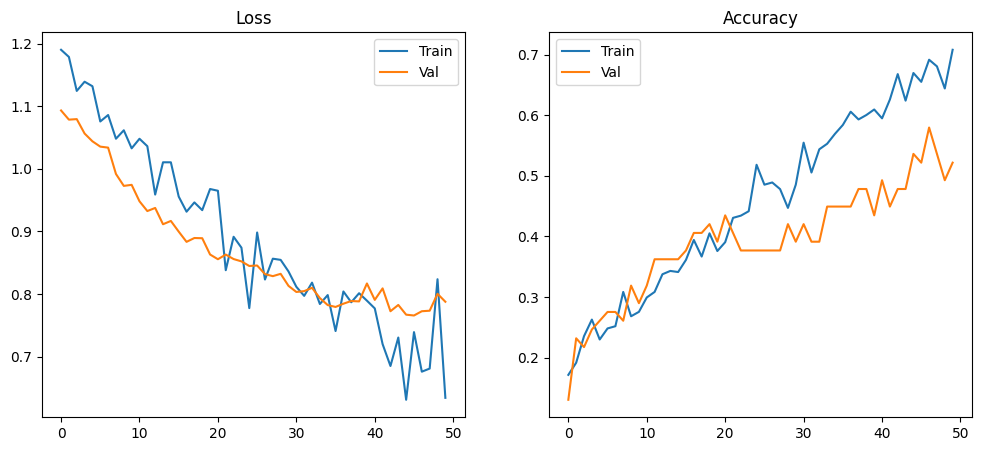

In [22]:
# Plot
with open("history.json", "r") as f: h = json.load(f)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(h['tr_loss'], label='Train')
plt.plot(h['val_loss'], label='Val')
plt.title("Loss"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(h['tr_acc'], label='Train')
plt.plot(h['val_acc'], label='Val')
plt.title("Accuracy"); plt.legend()
plt.show()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing:   0%|          | 0/5 [00:00<?, ?it/s]


--- Test Results ---
Accuracy: 0.4783
              precision    recall  f1-score   support

           0       0.12      0.17      0.14         6
           1       0.44      0.50      0.47        14
           2       0.67      0.63      0.65        19
           3       0.44      0.41      0.42        17
           4       0.55      0.46      0.50        13

    accuracy                           0.48        69
   macro avg       0.44      0.43      0.44        69
weighted avg       0.49      0.48      0.48        69



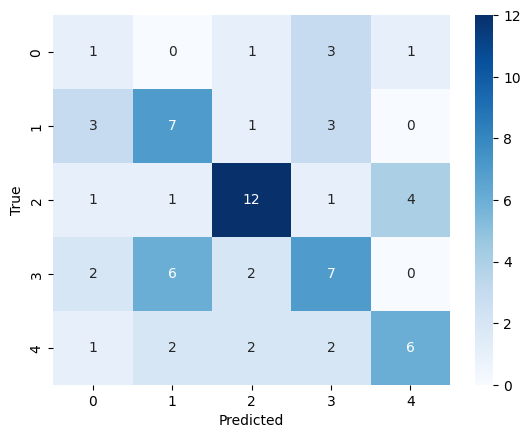

In [23]:
# Load Best Model
model = TriModalMER(n_classes=5).to(device)
model.load_state_dict(torch.load("best_trimodal.pt"))
model.eval()

test_ds = MIREXRobustDataset(test_ids, label_map, split="test")
test_dl = DataLoader(test_ds, batch_size=Config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

all_preds, all_labels = [], []

with torch.no_grad():
    for b in tqdm(test_dl, desc="Testing"):
        mel = b['mel'].to(device)
        ids = b['input_ids'].to(device)
        att = b['attention_mask'].to(device)
        m_img = b['midi_img'].to(device)
        m_ft = b['midi_feat'].to(device)
        ma = b['mask_a'].to(device)
        ml = b['mask_l'].to(device)
        hm = b['has_midi'].to(device)
        
        logits = model(mel, ids, att, m_img, m_ft, ma, ml, hm)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(b['label'].numpy())

print("\n--- Test Results ---")
print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()